# Text Classification - Vectorizers

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# load packages
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,HashingVectorizer
from sklearn import decomposition, ensemble
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
import pandas, xgboost, numpy, textblob, string
import pandas as pd
from nltk.stem.porter import PorterStemmer
import string
import joblib
import re
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from spacy.lang.en import English
from spacy.lang.en.examples import sentences #sample sentences
nlp = spacy.load('en_core_web_sm')
parser = English()

In [ ]:
parser

In [ ]:
# Stop words and special characters 
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS)) 
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","''"]

In [ ]:
def save_model(vectorizer,classifier,train_data,train_labels,test_data,test_label,pickle_name):
    # Initialize Pipeline
    vec_clf = Pipeline([('vectorizer', vectorizer), ('pac', classifier)])
    # fit the training dataset on the classifier
    vec_clf.fit(train_data,train_labels)
    # predict the labels on validation dataset
    predictions = vec_clf.predict(test_data)
    print(metrics.accuracy_score(predictions, test_label))
    # save Pipline
    joblib.dump(vec_clf, pickle_name, compress=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[Dataset Link - Kaggle](https://www.kaggle.com/datasets/yufengdev/bbc-fulltext-and-category?resource=download) - BBC Text Category CSV

In [ ]:
# load the dataset
trainDF = pd.read_csv('/content/bbc-text.csv')

In [ ]:
trainDF.head(10)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


In [ ]:
trainDF.shape

(2225, 2)

In [ ]:
trainDF.columns

Index(['category', 'text'], dtype='object')

In [ ]:
# change datatype to string
trainDF = trainDF[["category","text"]].astype(str)

In [ ]:
# check labels in category
trainDF['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [ ]:
# check counts of each category
trainDF['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [ ]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [ ]:
trainDF[trainDF.duplicated() == True].reset_index(drop=True)

,category,text
0,politics,hague given up his pm ambition former conser...
1,politics,fox attacks blair s tory lies tony blair lie...
2,tech,microsoft gets the blogging bug software giant...
3,business,economy strong in election year uk businesse...
4,entertainment,ray dvd beats box office takings oscar-nominat...
...,...,...
94,politics,kennedy questions trust of blair lib dem leade...
95,tech,california sets fines for spyware the makers o...
96,tech,progress on new internet domains by early 2005...
97,tech,junk e-mails on relentless rise spam traffic i...


In [ ]:
temp = trainDF.groupby(trainDF.columns.tolist(),as_index=False).size()
dupDF = temp[temp['size'] > 1]
dupDF

,category,text,size
127,business,economy strong in election year uk businesse...,2
255,business,jobs growth still slow in the us the us create...,2
354,business,s korea spending boost to economy south korea ...,2
368,business,sec to rethink post-enron rules the us stock m...,2
373,business,singapore growth at 8.1% in 2004 singapore s e...,2
...,...,...,...
2093,tech,us peer-to-peer pirates convicted the first co...,2
2102,tech,virus poses as christmas e-mail security firms...,2
2104,tech,warning over tsunami aid website net users are...,2
2111,tech,web radio takes spanish rap global spin the ra...,2


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


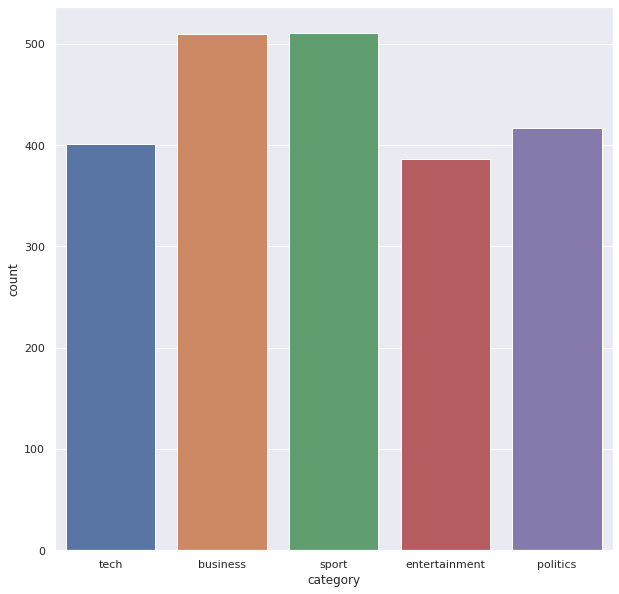

In [ ]:
# count plot
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(trainDF['category'])

## Data preparation

spaCy POS (Part-of-Speech) Dictionary:

```
ADJ: adjective, e.g. big, old, green, incomprehensible, first
ADP: adposition, e.g. in, to, during
ADV: adverb, e.g. very, tomorrow, down, where, there
AUX: auxiliary, e.g. is, has (done), will (do), should (do)
CONJ: conjunction, e.g. and, or, but
CCONJ: coordinating conjunction, e.g. and, or, but
DET: determiner, e.g. a, an, the
INTJ: interjection, e.g. psst, ouch, bravo, hello
NOUN: noun, e.g. girl, cat, tree, air, beauty
NUM: numeral, e.g. 1, 2017, one, seventy-seven, IV, MMXIV
PART: particle, e.g. ’s, not,
PRON: pronoun, e.g I, you, he, she, myself, themselves, somebody
PROPN: proper noun, e.g. Mary, John, London, NATO, HBO
PUNCT: punctuation, e.g. ., (, ), ?
SCONJ: subordinating conjunction, e.g. if, while, that
SYM: symbol, e.g. $, %, §, ©, +, −, ×, ÷, =, :), 😝
VERB: verb, e.g. run, runs, running, eat, ate, eating
X: other, e.g. sfpksdpsxmsa
SPACE: space, e.g.
```



In [ ]:
sentence = "The striped bats are hanging on their feet for best"
doc = nlp(sentence)

for token in doc:
    print(token.text, token.pos_,token.lemma_)

The DET the
striped VERB stripe
bats NOUN bat
are AUX be
hanging VERB hang
on ADP on
their PRON their
feet NOUN foot
for ADP for
best ADJ good


In [ ]:
# Data Cleaner and tokenizer
def tokenizeText(text):

    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    
    # tokens = parser(text)
    tokens = nlp(text)

    # print('Initial Tokens:', tokens)
    
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_)
    tokens = lemmas
    # print('\nLemmatized Tokens:', tokens)

    
    # remove stop words and special charaters
    tokens = [tok for tok in tokens if tok.lower() not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    tokens = [tok for tok in tokens if len(tok) >= 3]
    # print('\nStopword- and Special-Character Removed Tokens:', tokens)
    
    # remove remaining tokens that are not alphabetic
    tokens = [tok for tok in tokens if tok.isalpha()]
    
    # stemming of words
    #porter = PorterStemmer()
    #tokens = [porter.stem(word) for word in tokens]
    
    tokens = list(set(tokens)) #comment this if you want to keep the position of the words
    # print('\nFinal Tokens:', tokens)

    #return tokens
    return ' '.join(tokens[:])

In [ ]:
tokenizeText('The striped bats are hanging on their feet for best $#&*( ?')

'foot stripe bat hang good'

In [ ]:
# Data cleaning
trainDF['text_tokenized'] = trainDF['text'].apply(lambda x:tokenizeText(x))
trainDF.head()

,category,text,text_tokenized
0,tech,tv future in the hands of viewers with home th...,living function network president radically vi...
1,business,worldcom boss left books alone former worldc...,transform shareholder firm ability paint guilt...
2,sport,tigers wary of farrell gamble leicester say ...,rush big england leicester switch row bring li...
3,sport,yeading face newcastle in fa cup premiership s...,blackburn wigan scunthorpe coventry ryman port...
4,entertainment,ocean s twelve raids box office ocean s twelve...,president garcia snipe times big knock zeta ro...


In [ ]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['category'])
# train_x_tokenized, valid_x_tokenized, train_y_tokenized, valid_y_tokenized = model_selection.train_test_split(trainDF['text_tokenized'], trainDF['category'])
# 
# label encode the target variable 
#encoder = preprocessing.LabelEncoder()
#train_y = encoder.fit_transform(train_y)
#valid_y = encoder.fit_transform(valid_y)

## Feature Extraction and Visualization

### Count Vectors

In [ ]:
# Count Vectors as features
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(trainDF['text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [ ]:
xtrain_count.shape

(1668, 29457)

In [ ]:
#reduce data dimension using PCA
pca = PCA(n_components=2).fit(count_vect.transform(trainDF['text']).toarray())
data2D = pca.transform(count_vect.transform(trainDF['text']).toarray())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


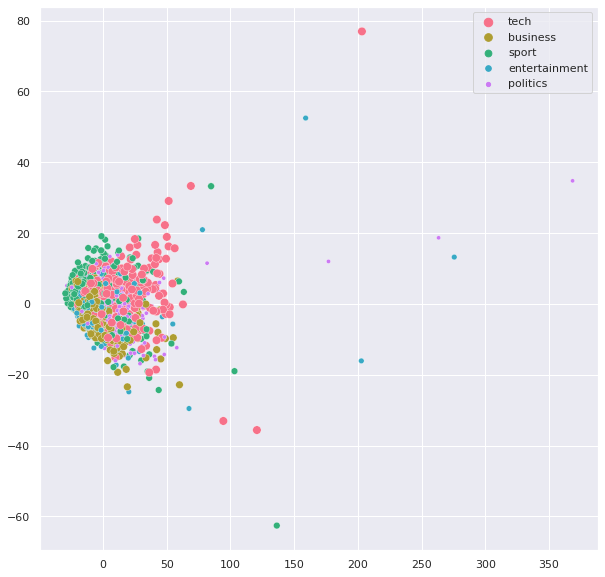

In [ ]:

# plot the features
ax = sns.scatterplot(data2D[:,0], data2D[:,1], hue=trainDF['category'].tolist(),size=trainDF['category'].tolist(),palette="husl")

In [ ]:
data2D

array([[ 31.43179908,  -0.68822582],
       [-14.59428377,   4.08861148],
       [-10.89006212,   3.51418087],
       ...,
       [ -8.70642047,   0.5097426 ],
       [ 47.72162373,   7.25963594],
       [-12.14618881,  -0.39023964]])

###  TF-IDF Vectors

TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

 TF-IDF Vectors as features
 
 a. Word Level TF-IDF : Matrix representing tf-idf scores of every term in different documents
 
 b. N-gram Level TF-IDF : N-grams are the combination of N terms together. This Matrix representing tf-idf scores  of N-grams
 
 c. Character Level TF-IDF : Matrix representing tf-idf scores of character level n-grams in the corpus

### word level tf-idf

`token pattern` is a regular expression (RegEx) which helps validate and match strings of a certain format.
[Read More](https://www3.ntu.edu.sg/home/ehchua/programming/howto/Regexe.html#zz-1.9)

The `\w` metacharacter matches word characters.

`\w{1,}` matches words that have one character or more.

In [ ]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', stop_words = 'english', max_features=5000)
tfidf_vect.fit(trainDF['text'])

xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

In [ ]:
xtrain_tfidf.shape

(1668, 5000)

In [ ]:
tfidf_vect.transform(trainDF['text']).toarray()

array([[0.        , 0.02305782, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02701881, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.03116481, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02136962, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
trainDF['text']

0       tv future in the hands of viewers with home th...
1       worldcom boss  left books alone  former worldc...
2       tigers wary of farrell  gamble  leicester say ...
3       yeading face newcastle in fa cup premiership s...
4       ocean s twelve raids box office ocean s twelve...
                              ...                        
2220    cars pull down us retail figures us retail sal...
2221    kilroy unveils immigration policy ex-chatshow ...
2222    rem announce new glasgow concert us band rem h...
2223    how political squabbles snowball it s become c...
2224    souness delight at euro progress boss graeme s...
Name: text, Length: 2225, dtype: object

In [ ]:
pca = PCA(n_components=2).fit(tfidf_vect.transform(trainDF['text']).toarray())
data2D = pca.transform(tfidf_vect.transform(trainDF['text']).toarray())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


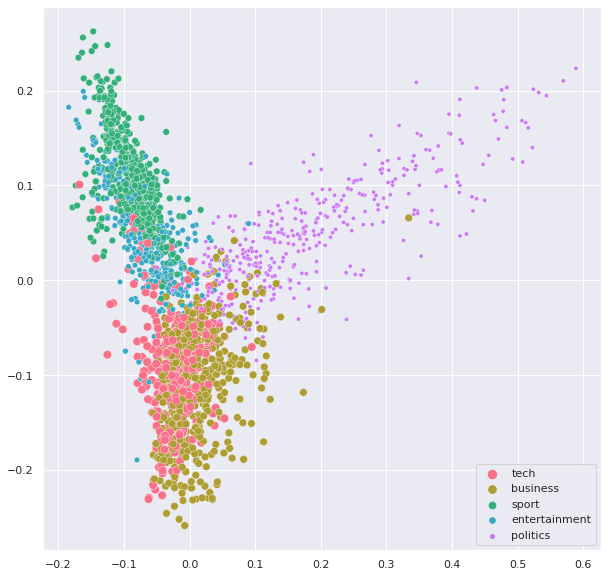

In [ ]:
# plot the features
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=trainDF['category'].tolist(),size=trainDF['category'].tolist(),palette="husl")

### ngram level tf-idf 

In [ ]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), stop_words = 'english', max_features=5000)
tfidf_vect_ngram.fit(trainDF['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


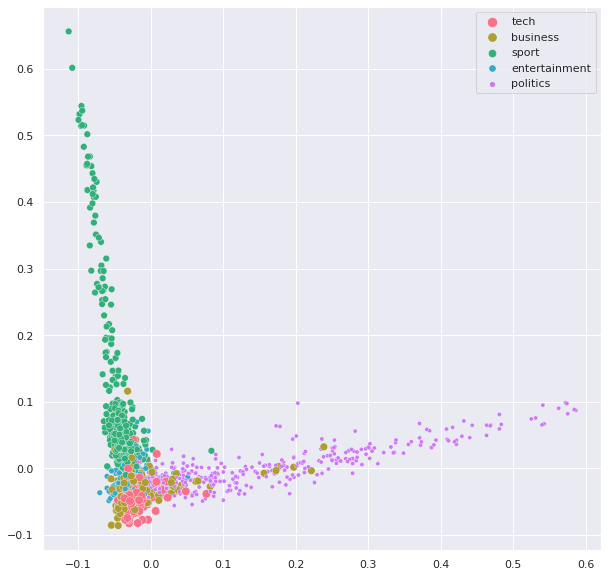

In [ ]:
# plot the features
pca = PCA(n_components=2).fit(tfidf_vect_ngram.transform(trainDF['text']).toarray())
data2D = pca.transform(tfidf_vect_ngram.transform(trainDF['text']).toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=trainDF['category'].tolist(),size=trainDF['category'].tolist(),palette="husl")

### characters level tf-idf

In [ ]:
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', max_features=5000)
tfidf_vect_ngram_chars.fit(trainDF['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


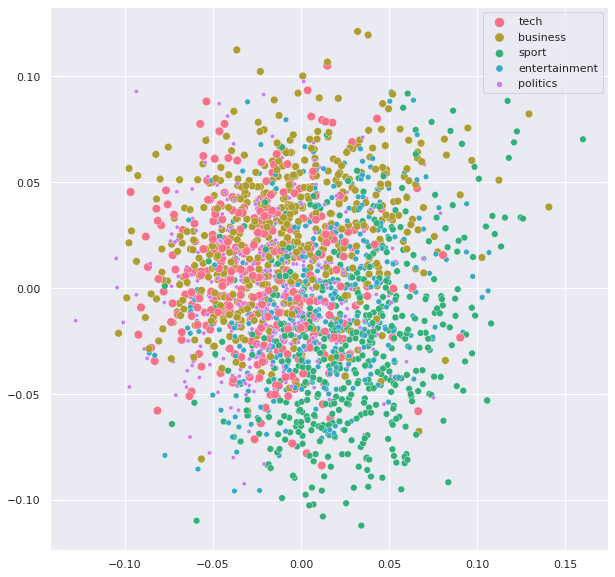

In [ ]:
# plot the features
pca = PCA(n_components=2).fit(tfidf_vect_ngram_chars.transform(trainDF['text']).toarray())
data2D = pca.transform(tfidf_vect_ngram_chars.transform(trainDF['text']).toarray())
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=trainDF['category'].tolist(),size=trainDF['category'].tolist(),palette="husl")

### HashingVectorizer

Output of Hashing Vectorizer will be a **Sparse Matrix**

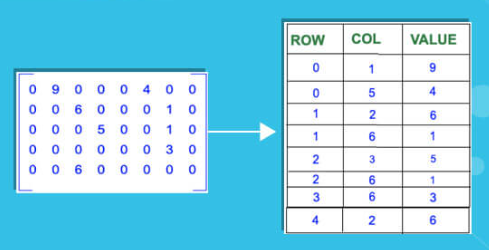

In [ ]:
vectorizer = HashingVectorizer(n_features = 4)
transformed = vectorizer.transform(['a very small document', 'another document'])
print(transformed)
print()
vectorizer2 = HashingVectorizer()
transformed2 = vectorizer2.transform(['a very small document', 'hello how are you'])
print(transformed2)


  (0, 0)	-0.4472135954999579
  (0, 2)	-0.8944271909999159
  (1, 0)	0.0

  (0, 70406)	-0.5773502691896258
  (0, 351664)	-0.5773502691896258
  (0, 538506)	-0.5773502691896258
  (1, 294069)	-0.5
  (1, 512176)	0.5
  (1, 784967)	0.5
  (1, 832412)	0.5


In [ ]:
# getting train features
hash_vectorizer = HashingVectorizer(n_features=5000)
hash_vectorizer.fit(trainDF['text'])
xtrain_hash_vectorizer =  hash_vectorizer.transform(train_x) 
xvalid_hash_vectorizer =  hash_vectorizer.transform(valid_x)

In [ ]:
hash_vectorizer.transform(trainDF['text']).toarray()

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.05785569,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.0112523 ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


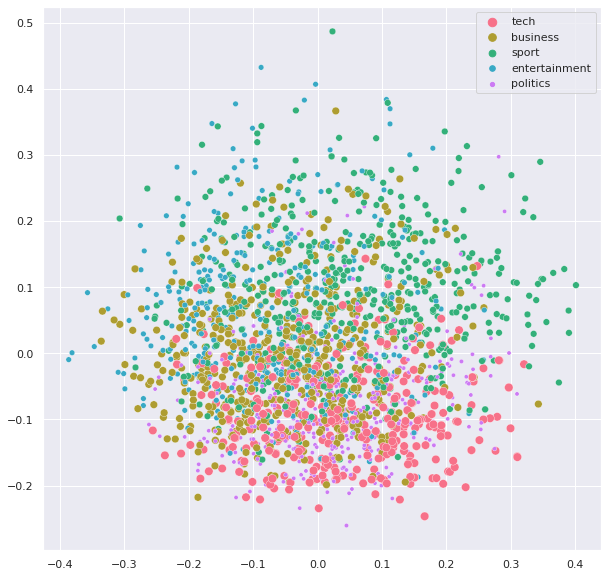

In [ ]:
# plot the features
pca = PCA(n_components=2).fit(hash_vectorizer.transform(trainDF['text']).toarray())
data2D = pca.transform(hash_vectorizer.transform(trainDF['text']).toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=trainDF['category'].tolist(),size=trainDF['category'].tolist(),palette="husl")

## Model Building

In [ ]:
'''
Generic Function for training with different classifiers and feature vectors
'''
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

### Naive Bayes

In [ ]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  0.9658886894075404
NB, WordLevel TF-IDF:  0.9730700179533214
NB, N-Gram Vectors:  0.9317773788150808
NB, CharLevel Vectors:  0.3500897666068223


### Linear Classifier

In [ ]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), xtrain_count, train_y, xvalid_count)
print("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), xtrain_tfidf, train_y, xvalid_tfidf)
print("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("LR, CharLevel Vectors: ", accuracy)

# Linear Classifier on Hash Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("LR, Hash Vectors: ", accuracy)

LR, Count Vectors:  0.9569120287253142
LR, WordLevel TF-IDF:  0.9730700179533214
LR, N-Gram Vectors:  0.9281867145421903
LR, CharLevel Vectors:  0.42010771992818674
LR, Hash Vectors:  0.9030520646319569


## Assignment: 


1.   Build 2 more models from Scikit Learn or other libraries (Support Vector Classifier, Ada Boost Classifier, Bagging Classifier, Random Forest Classifier, ...) 
2.   For each model, apply `x_train` from 3 types of Vectors (from Count, TF-IDF, N-Gram, Char, Hash Vectors)
3. Report Performance in terms of accuracy, precision, and recall.



# Generic precision function

In [ ]:
def train_model_pre(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.precision_score(predictions, valid_y, average='weighted')

# Support Vector Classifier- Linear Kernel

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# SVC on Count Vectors
accuracy = train_model(SVC(kernel='linear', C = 1.0), xtrain_count, train_y, xvalid_count)
print("SVC, Count Vectors Accuracy: ", accuracy)

# SVC on Word Level TF IDF Vectors
accuracy = train_model(SVC(kernel='linear', C = 1.0), xtrain_tfidf, train_y, xvalid_tfidf)
print("SVC, WordLevel TF-IDF: ", accuracy)

# SVC on Ngram Level TF IDF Vectors
accuracy = train_model(SVC(kernel='linear', C = 1.0), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVC, N-Gram Vectors: ", accuracy)

# SVC on Character Level TF IDF Vectors
accuracy = train_model(SVC(kernel='linear', C = 1.0), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("SVC, CharLevel Vectors: ", accuracy)

# SVC on Hash Vectors
accuracy = train_model(SVC(kernel='linear', C = 1.0), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("SVC, Hash Vectors: ", accuracy)

SVC, Count Vectors Accuracy:  0.9551166965888689
SVC, WordLevel TF-IDF:  0.9694793536804309
SVC, N-Gram Vectors:  0.9299820466786356
SVC, CharLevel Vectors:  0.3770197486535009
SVC, Hash Vectors:  0.9443447037701975


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# SVC on Count Vectors
precision = train_model_pre(SVC(kernel='linear', C = 1.0), xtrain_count, train_y, xvalid_count)
print("SVC, Count Vectors Precision: ", precision)

# SVC on Word Level TF IDF Vectors
precision= train_model_pre(SVC(kernel='linear', C = 1.0), xtrain_tfidf, train_y, xvalid_tfidf)
print("SVC, WordLevel TF-IDF Precision: ", precision)

# SVC on Ngram Level TF IDF Vectors
precision = train_model_pre(SVC(kernel='linear', C = 1.0), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVC, N-Gram Vectors Precision: ", precision)

# SVC on Character Level TF IDF Vectors
precision = train_model_pre(SVC(kernel='linear', C = 1.0), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("SVC, CharLevel Vectors Precision: ", precision)

# SVC on Hash Vectors
precision = train_model_pre(SVC(kernel='linear', C = 1.0), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("SVC, Hash Vectors Precision: ", precision)

SVC, Count Vectors Precision:  0.9557872847959633
SVC, WordLevel TF-IDF Precision:  0.9694605119075879
SVC, N-Gram Vectors Precision:  0.9315272100274626
SVC, CharLevel Vectors Precision:  0.8799097659489378
SVC, Hash Vectors Precision:  0.9448570254164131


# Generic Recall function

In [ ]:
def train_model_rec(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.recall_score(predictions, valid_y, average='weighted')

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# SVC on Count Vectors
recall = train_model_rec(SVC(kernel='linear', C = 1.0), xtrain_count, train_y, xvalid_count)
print("SVC, Count Vectors Recall: ", recall)

# SVC on Word Level TF IDF Vectors
recall= train_model_rec(SVC(kernel='linear', C = 1.0), xtrain_tfidf, train_y, xvalid_tfidf)
print("SVC, WordLevel TF-IDF Recall: ", recall)

# SVC on Ngram Level TF IDF Vectors
recall = train_model_rec(SVC(kernel='linear', C = 1.0), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVC, N-Gram Vectors Recall: ", recall)

# SVC on Character Level TF IDF Vectors
recall = train_model_rec(SVC(kernel='linear', C = 1.0), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("SVC, CharLevel Vectors Recall: ", recall)

# SVC on Hash Vectors
recall = train_model_rec(SVC(kernel='linear', C = 1.0), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("SVC, Hash Vectors Recall: ", recall)

SVC, Count Vectors Recall:  0.9551166965888689
SVC, WordLevel TF-IDF Recall:  0.9694793536804309
SVC, N-Gram Vectors Recall:  0.9299820466786356


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC, CharLevel Vectors Recall:  0.3770197486535009
SVC, Hash Vectors Recall:  0.9443447037701975


# Generic F1 function

In [ ]:
def train_model_f1(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.f1_score(predictions, valid_y, average='weighted')

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# SVC on Count Vectors
f1 = train_model_f1(SVC(kernel='linear', C = 1.0), xtrain_count, train_y, xvalid_count)
print("SVC, Count Vectors F1: ", f1)

# SVC on Word Level TF IDF Vectors
f1= train_model_rec(SVC(kernel='linear', C = 1.0), xtrain_tfidf, train_y, xvalid_tfidf)
print("SVC, WordLevel TF-IDF F1: ", f1)

# SVC on Ngram Level TF IDF Vectors
f1 = train_model_rec(SVC(kernel='linear', C = 1.0), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVC, N-Gram Vectors F1: ", f1)

# SVC on Character Level TF IDF Vectors
f1 = train_model_rec(SVC(kernel='linear', C = 1.0), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("SVC, CharLevel Vectors F1: ", f1)

# SVC on Hash Vectors
f1 = train_model_rec(SVC(kernel='linear', C = 1.0), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("SVC, Hash Vectors F1: ", f1)

SVC, Count Vectors F1:  0.9553015857422296
SVC, WordLevel TF-IDF F1:  0.9694793536804309
SVC, N-Gram Vectors F1:  0.9299820466786356


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC, CharLevel Vectors F1:  0.3770197486535009
SVC, Hash Vectors F1:  0.9443447037701975


# Support Vector Classifier- RBF Kernel

In [ ]:
from sklearn.svm import SVC
# SVC on Count Vectors
accuracy = train_model(SVC(kernel='rbf', C = 1.0), xtrain_count, train_y, xvalid_count)
print("SVC, Count Vectors: ", accuracy)

# SVC on Word Level TF IDF Vectors
accuracy = train_model(SVC(kernel='rbf', C = 1.0), xtrain_tfidf, train_y, xvalid_tfidf)
print("SVC, WordLevel TF-IDF: ", accuracy)

# SVC on Ngram Level TF IDF Vectors
accuracy = train_model(SVC(kernel='rbf', C = 1.0), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVC, N-Gram Vectors: ", accuracy)

# SVC on Character Level TF IDF Vectors
accuracy = train_model(SVC(kernel='rbf', C = 1.0), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("SVC, CharLevel Vectors: ", accuracy)

# SVC on Hash Vectors
accuracy = train_model(SVC(kernel='rbf', C = 1.0), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("SVC, Hash Vectors: ", accuracy)

SVC, Count Vectors:  0.926391382405745
SVC, WordLevel TF-IDF:  0.9676840215439856
SVC, N-Gram Vectors:  0.926391382405745
SVC, CharLevel Vectors:  0.5583482944344704
SVC, Hash Vectors:  0.9497307001795332


# Precision

In [ ]:
from sklearn.svm import SVC
# SVC on Count Vectors
precision = train_model_pre(SVC(kernel='rbf', C = 1.0), xtrain_count, train_y, xvalid_count)
print("SVC, Count Vectors: ", precision)

# SVC on Word Level TF IDF Vectors
precision = train_model_pre(SVC(kernel='rbf', C = 1.0), xtrain_tfidf, train_y, xvalid_tfidf)
print("SVC, WordLevel TF-IDF: ", precision)

# SVC on Ngram Level TF IDF Vectors
precision = train_model_pre(SVC(kernel='rbf', C = 1.0), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVC, N-Gram Vectors: ", precision)

# SVC on Character Level TF IDF Vectors
precision = train_model_pre(SVC(kernel='rbf', C = 1.0), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("SVC, CharLevel Vectors: ", precision)

# SVC on Hash Vectors
precision = train_model_pre(SVC(kernel='rbf', C = 1.0), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("SVC, Hash Vectors: ", precision)

SVC, Count Vectors:  0.9313595687306031
SVC, WordLevel TF-IDF:  0.9675881476663327
SVC, N-Gram Vectors:  0.9294278237080374
SVC, CharLevel Vectors:  0.6589776413083461
SVC, Hash Vectors:  0.9504407181427903


# Recall

In [ ]:
from sklearn.svm import SVC
# SVC on Count Vectors
recall = train_model_rec(SVC(kernel='rbf', C = 1.0), xtrain_count, train_y, xvalid_count)
print("SVC, Count Vectors: ", recall)

# SVC on Word Level TF IDF Vectors
recall = train_model_rec(SVC(kernel='rbf', C = 1.0), xtrain_tfidf, train_y, xvalid_tfidf)
print("SVC, WordLevel TF-IDF: ", recall)

# SVC on Ngram Level TF IDF Vectors
recall = train_model_rec(SVC(kernel='rbf', C = 1.0), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVC, N-Gram Vectors: ", recall)

# SVC on Character Level TF IDF Vectors
recall = train_model_rec(SVC(kernel='rbf', C = 1.0), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("SVC, CharLevel Vectors: ", recall)

# SVC on Hash Vectors
recall = train_model_rec(SVC(kernel='rbf', C = 1.0), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("SVC, Hash Vectors: ", recall)

SVC, Count Vectors:  0.926391382405745
SVC, WordLevel TF-IDF:  0.9676840215439856
SVC, N-Gram Vectors:  0.926391382405745
SVC, CharLevel Vectors:  0.5583482944344704
SVC, Hash Vectors:  0.9497307001795332


# F1 score

In [ ]:
# SVC on Count Vectors
f1 = train_model_f1(SVC(kernel='rbf', C = 1.0), xtrain_count, train_y, xvalid_count)
print("SVC, Count Vectors: ", f1)

# SVC on Word Level TF IDF Vectors
f1 = train_model_f1(SVC(kernel='rbf', C = 1.0), xtrain_tfidf, train_y, xvalid_tfidf)
print("SVC, WordLevel TF-IDF: ", f1)

# SVC on Ngram Level TF IDF Vectors
f1 = train_model_f1(SVC(kernel='rbf', C = 1.0), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVC, N-Gram Vectors: ", f1)

# SVC on Character Level TF IDF Vectors
f1 = train_model_f1(SVC(kernel='rbf', C = 1.0), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("SVC, CharLevel Vectors: ", f1)

# SVC on Hash Vectors
f1 = train_model_f1(SVC(kernel='rbf', C = 1.0), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("SVC, Hash Vectors: ", f1)

SVC, Count Vectors:  0.9268494001952926
SVC, WordLevel TF-IDF:  0.9675499577418875
SVC, N-Gram Vectors:  0.9264543410023556
SVC, CharLevel Vectors:  0.5767716551451757
SVC, Hash Vectors:  0.9497607608915551


# Support Vector Classifier- Poly Kernel

In [ ]:
from sklearn.svm import SVC
# SVC on Count Vectors
accuracy = train_model(SVC(kernel='poly', C = 1.0), xtrain_count, train_y, xvalid_count)
print("SVC, Count Vectors: ", accuracy)

# SVC on Word Level TF IDF Vectors
accuracy = train_model(SVC(kernel='poly', C = 1.0), xtrain_tfidf, train_y, xvalid_tfidf)
print("SVC, WordLevel TF-IDF: ", accuracy)

# SVC on Ngram Level TF IDF Vectors
accuracy = train_model(SVC(kernel='poly', C = 1.0), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVC, N-Gram Vectors: ", accuracy)

# SVC on Character Level TF IDF Vectors
accuracy = train_model(SVC(kernel='poly', C = 1.0), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("SVC, CharLevel Vectors: ", accuracy)

# SVC on Hash Vectors
accuracy = train_model(SVC(kernel='poly', C = 1.0), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("SVC, Hash Vectors: ", accuracy)

SVC, Count Vectors:  0.6678635547576302
SVC, WordLevel TF-IDF:  0.7863554757630161
SVC, N-Gram Vectors:  0.5978456014362658
SVC, CharLevel Vectors:  0.5978456014362658
SVC, Hash Vectors:  0.9515260323159784


# Precision

In [ ]:
# SVC on Count Vectors
precision = train_model_pre(SVC(kernel='poly', C = 1.0), xtrain_count, train_y, xvalid_count)
print("SVC, Count Vectors: ", precision)

# SVC on Word Level TF IDF Vectors
precision = train_model_pre(SVC(kernel='poly', C = 1.0), xtrain_tfidf, train_y, xvalid_tfidf)
print("SVC, WordLevel TF-IDF: ", precision)

# SVC on Ngram Level TF IDF Vectors
precision = train_model_pre(SVC(kernel='poly', C = 1.0), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVC, N-Gram Vectors: ", precision)

# SVC on Character Level TF IDF Vectors
precision = train_model_pre(SVC(kernel='poly', C = 1.0), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("SVC, CharLevel Vectors: ", precision)

# SVC on Hash Vectors
precision = train_model_pre(SVC(kernel='poly', C = 1.0), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("SVC, Hash Vectors: ", precision)

SVC, Count Vectors:  0.7727614941993316
SVC, WordLevel TF-IDF:  0.845969029708187
SVC, N-Gram Vectors:  0.8176881114595714
SVC, CharLevel Vectors:  0.6284052311060879
SVC, Hash Vectors:  0.9519897270456039


# Recall

In [ ]:
# SVC on Count Vectors
recall = train_model_rec(SVC(kernel='poly', C = 1.0), xtrain_count, train_y, xvalid_count)
print("SVC, Count Vectors: ", recall)

# SVC on Word Level TF IDF Vectors
recall = train_model_rec(SVC(kernel='poly', C = 1.0), xtrain_tfidf, train_y, xvalid_tfidf)
print("SVC, WordLevel TF-IDF: ", recall)

# SVC on Ngram Level TF IDF Vectors
recall = train_model_rec(SVC(kernel='poly', C = 1.0), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVC, N-Gram Vectors: ", recall)

# SVC on Character Level TF IDF Vectors
recall = train_model_rec(SVC(kernel='poly', C = 1.0), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("SVC, CharLevel Vectors: ", recall)

# SVC on Hash Vectors
recall = train_model_rec(SVC(kernel='poly', C = 1.0), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("SVC, Hash Vectors: ", recall)

SVC, Count Vectors:  0.6678635547576302
SVC, WordLevel TF-IDF:  0.7863554757630161
SVC, N-Gram Vectors:  0.5978456014362658
SVC, CharLevel Vectors:  0.5978456014362658
SVC, Hash Vectors:  0.9515260323159784


# Ada Boost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
# Adaboost on Count Vectors
accuracy = train_model(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_count, train_y, xvalid_count)
print("Adaboost, Count Vectors: ", accuracy)

# Adaboost on Word Level TF IDF Vectors
accuracy = train_model(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_tfidf, train_y, xvalid_tfidf)
print("Adaboost, WordLevel TF-IDF: ", accuracy)

# Adaboost on Ngram Level TF IDF Vectors
accuracy = train_model(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Adaboost, N-Gram Vectors: ", accuracy)

# Adaboost on Character Level TF IDF Vectors
accuracy = train_model(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Adaboost, CharLevel Vectors: ", accuracy)

# Adaboost on Hash Vectors
accuracy = train_model(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("Adaboost, Hash Vectors: ", accuracy)

Adaboost, Count Vectors:  0.7522441651705566
Adaboost, WordLevel TF-IDF:  0.7378815080789947
Adaboost, N-Gram Vectors:  0.6086175942549371
Adaboost, CharLevel Vectors:  0.6391382405745063
Adaboost, Hash Vectors:  0.7630161579892281


# Precision

In [ ]:
# Adaboost on Count Vectors
precision = train_model_pre(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_count, train_y, xvalid_count)
print("Adaboost, Count Vectors: ", precision)

# Adaboost on Word Level TF IDF Vectors
precision = train_model_pre(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_tfidf, train_y, xvalid_tfidf)
print("Adaboost, WordLevel TF-IDF: ", precision)

# Adaboost on Ngram Level TF IDF Vectors
precision = train_model_pre(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Adaboost, N-Gram Vectors: ", precision)

# Adaboost on Character Level TF IDF Vectors
precision = train_model_pre(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Adaboost, CharLevel Vectors: ", precision)

# Adaboost on Hash Vectors
precision = train_model_pre(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("Adaboost, Hash Vectors: ", precision)

Adaboost, Count Vectors:  0.7854910596273117
Adaboost, WordLevel TF-IDF:  0.7611738613433241
Adaboost, N-Gram Vectors:  0.6427486359500688
Adaboost, CharLevel Vectors:  0.656815604201349
Adaboost, Hash Vectors:  0.7753898585150721


# Recall

In [ ]:
# Adaboost on Count Vectors
recall = train_model_rec(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_count, train_y, xvalid_count)
print("Adaboost, Count Vectors: ", recall)

# Adaboost on Word Level TF IDF Vectors
recall = train_model_rec(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_tfidf, train_y, xvalid_tfidf)
print("Adaboost, WordLevel TF-IDF: ", recall)

# Adaboost on Ngram Level TF IDF Vectors
recall = train_model_rec(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Adaboost, N-Gram Vectors: ", recall)

# Adaboost on Character Level TF IDF Vectors
recall = train_model_rec(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Adaboost, CharLevel Vectors: ", recall)

# Adaboost on Hash Vectors
recall = train_model_rec(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("Adaboost, Hash Vectors: ", recall)

Adaboost, Count Vectors:  0.7522441651705566
Adaboost, WordLevel TF-IDF:  0.7378815080789947
Adaboost, N-Gram Vectors:  0.6086175942549371
Adaboost, CharLevel Vectors:  0.6391382405745063
Adaboost, Hash Vectors:  0.7630161579892281


# F1

In [ ]:
# Adaboost on Count Vectors
f1 = train_model_f1(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_count, train_y, xvalid_count)
print("Adaboost, Count Vectors: ", f1)

# Adaboost on Word Level TF IDF Vectors
f1 = train_model_f1(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_tfidf, train_y, xvalid_tfidf)
print("Adaboost, WordLevel TF-IDF: ", f1)

# Adaboost on Ngram Level TF IDF Vectors
f1 = train_model_f1(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Adaboost, N-Gram Vectors: ", f1)

# Adaboost on Character Level TF IDF Vectors
f1 = train_model_f1(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Adaboost, CharLevel Vectors: ", f1)

# Adaboost on Hash Vectors
f1 = train_model_f1(AdaBoostClassifier(n_estimators=50, learning_rate=1), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("Adaboost, Hash Vectors: ", f1)

Adaboost, Count Vectors:  0.7490326935664534
Adaboost, WordLevel TF-IDF:  0.7342855596072917
Adaboost, N-Gram Vectors:  0.5894427325498757
Adaboost, CharLevel Vectors:  0.6452147374015473
Adaboost, Hash Vectors:  0.7517678305606315


# Bagging Classifier

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
# Bagging Classifier on Count Vectors
accuracy = train_model(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_count, train_y, xvalid_count)
print("Bagging Classifier, Count Vectors: ", accuracy)

# Bagging Classifier on Word Level TF IDF Vectors
accuracy = train_model(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf, train_y, xvalid_tfidf)
print("Bagging Classifier, WordLevel TF-IDF: ", accuracy)

# Bagging Classifier on Word Level TF IDF Vectors
accuracy = train_model(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf, train_y, xvalid_tfidf)
print("Bagging Classifier, WordLevel TF-IDF: ", accuracy)

# Bagging Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Bagging Classifier, N-Gram Vectors: ", accuracy)

# Bagging Classifier on Character Level TF IDF Vectors
accuracy = train_model(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Bagging Classifier, CharLevel Vectors: ", accuracy)

# Bagging Classifier on Hash Vectors
accuracy = train_model(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("Bagging Classifier, Hash Vectors: ", accuracy)

Bagging Classifier, Count Vectors:  0.8617594254937163
Bagging Classifier, WordLevel TF-IDF:  0.895870736086176
Bagging Classifier, WordLevel TF-IDF:  0.895870736086176
Bagging Classifier, N-Gram Vectors:  0.77737881508079
Bagging Classifier, CharLevel Vectors:  0.7342908438061041
Bagging Classifier, Hash Vectors:  0.8420107719928187


# Precision

In [ ]:
# Bagging Classifier on Count Vectors
precision = train_model_pre(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_count, train_y, xvalid_count)
print("Bagging Classifier, Count Vectors: ", precision)

# Bagging Classifier on Word Level TF IDF Vectors
precision = train_model_pre(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf, train_y, xvalid_tfidf)
print("Bagging Classifier, WordLevel TF-IDF: ", precision)

# Bagging Classifier on Word Level TF IDF Vectors
precision = train_model_pre(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf, train_y, xvalid_tfidf)
print("Bagging Classifier, WordLevel TF-IDF: ", precision)

# Bagging Classifier on Ngram Level TF IDF Vectors
precision = train_model_pre(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Bagging Classifier, N-Gram Vectors: ", precision)

# Bagging Classifier on Character Level TF IDF Vectors
precision = train_model_pre(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Bagging Classifier, CharLevel Vectors: ", precision)

# Bagging Classifier on Hash Vectors
precision = train_model_pre(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("Bagging Classifier, Hash Vectors: ", precision)

Bagging Classifier, Count Vectors:  0.866574208837336
Bagging Classifier, WordLevel TF-IDF:  0.9027655201695824
Bagging Classifier, WordLevel TF-IDF:  0.9027655201695824
Bagging Classifier, N-Gram Vectors:  0.781985583392099
Bagging Classifier, CharLevel Vectors:  0.7497712886618899
Bagging Classifier, Hash Vectors:  0.849595027924497


# recall

In [ ]:
# Bagging Classifier on Count Vectors
recall = train_model_rec(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_count, train_y, xvalid_count)
print("Bagging Classifier, Count Vectors: ", recall)

# Bagging Classifier on Word Level TF IDF Vectors
recall = train_model_rec(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf, train_y, xvalid_tfidf)
print("Bagging Classifier, WordLevel TF-IDF: ", recall)

# Bagging Classifier on Word Level TF IDF Vectors
recall = train_model_rec(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf, train_y, xvalid_tfidf)
print("Bagging Classifier, WordLevel TF-IDF: ", recall)

# Bagging Classifier on Ngram Level TF IDF Vectors
recall = train_model_rec(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Bagging Classifier, N-Gram Vectors: ", recall)

# Bagging Classifier on Character Level TF IDF Vectors
recall = train_model_rec(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Bagging Classifier, CharLevel Vectors: ", recall)

# Bagging Classifier on Hash Vectors
recall = train_model_rec(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("Bagging Classifier, Hash Vectors: ", recall)

Bagging Classifier, Count Vectors:  0.8617594254937163
Bagging Classifier, WordLevel TF-IDF:  0.895870736086176
Bagging Classifier, WordLevel TF-IDF:  0.895870736086176
Bagging Classifier, N-Gram Vectors:  0.77737881508079
Bagging Classifier, CharLevel Vectors:  0.7342908438061041
Bagging Classifier, Hash Vectors:  0.8420107719928187


# F1 score

In [ ]:
# Bagging Classifier on Count Vectors
f1 = train_model_f1(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_count, train_y, xvalid_count)
print("Bagging Classifier, Count Vectors: ", f1)

# Bagging Classifier on Word Level TF IDF Vectors
f1 = train_model_f1(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf, train_y, xvalid_tfidf)
print("Bagging Classifier, WordLevel TF-IDF: ", f1)

# Bagging Classifier on Ngram Level TF IDF Vectors
f1 = train_model_f1(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Bagging Classifier, N-Gram Vectors: ", f1)

# Bagging Classifier on Character Level TF IDF Vectors
f1 = train_model_f1(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Bagging Classifier, CharLevel Vectors: ", f1)

# Bagging Classifier on Hash Vectors
f1 = train_model_f1(BaggingClassifier( n_estimators = 100,random_state = 8), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("Bagging Classifier, Hash Vectors: ",f1)

Bagging Classifier, Count Vectors:  0.8607706336800113
Bagging Classifier, WordLevel TF-IDF:  0.8967974456386578
Bagging Classifier, N-Gram Vectors:  0.7734557428541594
Bagging Classifier, CharLevel Vectors:  0.7376288866613178
Bagging Classifier, Hash Vectors:  0.8426374925524013


# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Random forest Classifier on Count Vectors
accuracy = train_model(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_count, train_y, xvalid_count)
print("Random forest Classifier, Count Vectors: ", accuracy)

# Random forest Classifier on Word Level TF IDF Vectors
accuracy = train_model(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf, train_y, xvalid_tfidf)
print("Random forest Classifier, WordLevel TF-IDF: ", accuracy)

# Random forest Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Random forest Classifier, N-Gram Vectors: ", accuracy)

# Random forest Classifier on Character Level TF IDF Vectors
accuracy = train_model(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Random forest Classifier, CharLevel Vectors: ", accuracy)

# Random forest Classifier on Hash Vectors
accuracy = train_model(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("Random forest Classifier, Hash Vectors: ", accuracy)

Random forest Classifier, Count Vectors:  0.9371633752244165
Random forest Classifier, WordLevel TF-IDF:  0.9569120287253142
Random forest Classifier, N-Gram Vectors:  0.8402154398563735
Random forest Classifier, CharLevel Vectors:  0.718132854578097
Random forest Classifier, Hash Vectors:  0.9389587073608617


# Precision

In [ ]:
# Random forest Classifier on Count Vectors
precision = train_model_pre(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_count, train_y, xvalid_count)
print("Random forest Classifier, Count Vectors: ", precision)

# Random forest Classifier on Word Level TF IDF Vectors
precision = train_model_pre(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf, train_y, xvalid_tfidf)
print("Random forest Classifier, WordLevel TF-IDF: ", precision)

# Random forest Classifier on Ngram Level TF IDF Vectors
precision = train_model_pre(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Random forest Classifier, N-Gram Vectors: ", precision)

# Random forest Classifier on Character Level TF IDF Vectors
precision = train_model_pre(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Random forest Classifier, CharLevel Vectors: ", precision)

# Random forest Classifier on Hash Vectors
precision = train_model_pre(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("Random forest Classifier, Hash Vectors: ", precision)

Random forest Classifier, Count Vectors:  0.9403880993998969
Random forest Classifier, WordLevel TF-IDF:  0.9577625352126377
Random forest Classifier, N-Gram Vectors:  0.8423029135834025
Random forest Classifier, CharLevel Vectors:  0.7509553113635852
Random forest Classifier, Hash Vectors:  0.9424078717413004


# Recall

In [ ]:
# Random forest Classifier on Count Vectors
recall = train_model_rec(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_count, train_y, xvalid_count)
print("Random forest Classifier, Count Vectors: ", recall)

# Random forest Classifier on Word Level TF IDF Vectors
recall = train_model_rec(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf, train_y, xvalid_tfidf)
print("Random forest Classifier, WordLevel TF-IDF: ", recall)

# Random forest Classifier on Ngram Level TF IDF Vectors
recall = train_model_rec(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Random forest Classifier, N-Gram Vectors: ", recall)

# Random forest Classifier on Character Level TF IDF Vectors
recall = train_model_rec(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Random forest Classifier, CharLevel Vectors: ", recall)

# Random forest Classifier on Hash Vectors
recall = train_model_rec(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("Random forest Classifier, Hash Vectors: ", recall)

Random forest Classifier, Count Vectors:  0.9371633752244165
Random forest Classifier, WordLevel TF-IDF:  0.9569120287253142
Random forest Classifier, N-Gram Vectors:  0.8402154398563735
Random forest Classifier, CharLevel Vectors:  0.718132854578097
Random forest Classifier, Hash Vectors:  0.9389587073608617


# F1

In [ ]:
# Random forest Classifier on Count Vectors
f1 = train_model_f1(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_count, train_y, xvalid_count)
print("Random forest Classifier, Count Vectors: ", f1)

# Random forest Classifier on Word Level TF IDF Vectors
f1 = train_model_f1(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf, train_y, xvalid_tfidf)
print("Random forest Classifier, WordLevel TF-IDF: ", f1)

# Random forest Classifier on Ngram Level TF IDF Vectors
f1 = train_model_f1(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Random forest Classifier, N-Gram Vectors: ", f1)

# Random forest Classifier on Character Level TF IDF Vectors
f1 = train_model_f1(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Random forest Classifier, CharLevel Vectors: ", f1)

# Random forest Classifier on Hash Vectors
f1 = train_model_f1(RandomForestClassifier( n_estimators = 100,random_state = 8), xtrain_hash_vectorizer, train_y, xvalid_hash_vectorizer)
print("Random forest Classifier, Hash Vectors: ", f1)

Random forest Classifier, Count Vectors:  0.9373430624547366
Random forest Classifier, WordLevel TF-IDF:  0.9569258768052527
Random forest Classifier, N-Gram Vectors:  0.8370438759519864
Random forest Classifier, CharLevel Vectors:  0.7244997047404108
Random forest Classifier, Hash Vectors:  0.9382687888220574


# Summary

From this project, I learned the following points:
* Use of Tf-IDF
* Use of pipeline
* Use of Wordlevel TF-IDF, N-Gram vectors, character level vectors, Hash Vectors
* Use of Multiclass Classification
* Analyzing Accuracy, precision, recall F1 score of multiclass classification

## Discussion

Working with this ICP I faced some confussion during measuring precision, recall and F1 score using "micro" and "macro" as average and notice that values are almost same. Using average="weighted" I saw the difference